#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 100

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.11238772,  0.9900117 ,  0.08512251],
       [-0.37633537,  0.12169232, -0.91845668],
       [-0.91964161,  0.07118864,  0.38625314]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002688


In [33]:
Ret.shape

(100, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000367


In [37]:
C1(dx,dy,dz,Ret)

array([[ 2.96254694e-01, -6.43323180e-01, -3.89303268e+00,
        -1.06803103e-02, -2.14822648e-01,  1.04473880e+00,
         1.95521527e-02, -1.09974918e-01,  3.24109953e+00,
        -1.70095489e-04,  3.25955008e-01,  1.06530375e-02,
        -1.43779989e+00,  1.65290299e+00, -1.25413382e+00,
         1.66595786e+00, -1.00140322e-01, -8.42361113e-01,
        -5.19716360e-01, -4.60286312e-01,  1.87158085e-01,
        -1.01281635e-01,  3.01828044e-01, -1.09790996e-01,
        -1.23600427e+00,  3.66628517e-02, -1.87051520e-03,
        -2.02250179e+00, -4.91433884e-02,  7.08157827e-04,
        -3.07870504e-02, -1.77449887e-01, -1.30217439e+00,
         4.25638540e+00, -2.89865290e-01,  3.18734917e-01,
        -1.12079469e-02,  1.99532924e+00, -8.16347844e-01,
         1.49457273e+00,  1.53549477e+00, -3.05924825e+00,
         2.08980198e+00,  1.32328630e+00, -5.25782791e+00,
         8.15723763e-01,  4.58294493e-01,  4.63069595e-02,
         2.19814156e-01,  2.81709103e-01, -2.92922629e+0

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.70021574e+03, -6.99550285e+03, -4.26051877e+04],
       [-3.69205356e+03,  7.23914161e+03, -1.60009810e+04],
       [-2.23422467e+04, -8.89985660e+03, -2.95102351e+03],
       [-6.12946635e+01,  9.62700532e+03, -2.67230163e+03],
       [-1.23287447e+03, -5.81929404e+03,  1.99043388e+04],
       [ 5.99579141e+03,  7.66048465e+03,  2.12192576e+02],
       [ 1.12210468e+02, -6.30805183e+03,  1.68999410e+04],
       [-6.31149785e+02,  5.99282398e+03, -2.54286254e+03],
       [ 1.86007802e+04, -4.35441380e+03, -6.52258692e+03],
       [-9.76183784e-01,  1.74387455e+02,  1.41184187e+02],
       [ 1.87066685e+03,  2.53175700e+03, -3.55818938e+03],
       [ 6.11381440e+01,  6.85508207e+03, -6.91432193e+02],
       [-8.25158235e+03,  5.37421293e+01, -1.95644063e+01],
       [ 9.48606635e+03,  1.41990774e+01, -1.15943191e+04],
       [-7.19751653e+03, -4.40075761e+02,  1.06557968e+04],
       [ 9.56098867e+03, -5.96354913e+03,  8.79237184e+03],
       [-5.74708707e+02,  8.62066182e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000277


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000166


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000025


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-1.23410339e+00,  3.67647219e-02,  9.72216461e-02],
       [-5.05908483e-01, -2.43576567e+00,  1.63608186e+00],
       [-9.51000636e-01, -9.70566232e-02, -1.23411667e+00],
       [ 6.43914173e-01,  2.93517787e-02, -1.55946432e+00],
       [-1.06779415e+00,  6.66929300e-01,  5.07799987e-01],
       [-5.84022711e-01, -1.43208128e+00, -7.50011809e-01],
       [ 9.10897558e-01,  1.02636853e+00, -7.83123517e-01],
       [ 1.29747370e+00,  3.14260540e+00, -4.38374099e-01],
       [-7.29921785e-02,  4.46936513e-01,  8.21569404e-01],
       [-9.60688410e-01,  1.88933672e+00,  7.26661902e-01],
       [ 5.83818278e-01, -1.74809495e-01, -2.01097495e-01],
       [ 1.13057373e+00,  6.65581077e-01,  7.49953675e-01],
       [ 2.14374441e+00, -7.82066804e-01, -6.72890182e-01],
       [-1.02835898e+00,  1.31090082e+00, -1.73739478e+00],
       [-1.37318060e+00,  9.09201395e-01, -2.89770656e-02],
       [-1.14595715e+00,  2.23148018e-01, -2.26716771e-01],
       [ 2.55281909e-01, -1.64968694e+00

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000204


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001042


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000881


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.84481437,  0.40382437,  0.46349118],
       [ 1.02979215,  1.37237474, -0.73647051],
       [ 0.88633995, -0.44953123,  1.39224301],
       [ 0.14071713,  0.06915863,  1.61308311],
       [-1.0679083 , -0.62147133, -0.55790678],
       [-0.11612349, -0.22845921,  0.93064553],
       [ 0.70093151, -1.23854591,  0.89223903],
       [-1.32003509, -0.95849637, -0.07962988],
       [ 1.01366396, -0.38129462, -0.38574738],
       [-0.24308604,  1.16825146,  1.57260271],
       [ 0.58075759, -2.07384503, -0.82189853],
       [-1.17142196, -0.01474247, -0.18843133],
       [-0.05331785, -0.74392033,  0.62512544],
       [ 0.48429646, -0.69490975,  0.2734835 ],
       [-0.26892143,  1.21795519, -1.53321116],
       [-2.30983141, -0.68261628, -0.08961149],
       [ 0.43015081,  2.28118805,  0.59255108],
       [ 0.72237916,  0.60998109, -0.8100579 ],
       [-0.24524389,  1.68668628, -1.40017067],
       [-0.61505565,  0.65590811,  0.45055865],
       [ 2.36618263,  0.09749869, -0.526

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 5.46128655e-04,  3.65264951e-02, -1.02404917e-02,
        -1.43004622e-02, -1.39767854e-03,  6.06514286e-03,
        -1.62349638e-02, -3.20710353e-02,  3.39560772e-03,
        -1.03675663e-02, -2.45744245e-04,  7.94174035e-04,
         9.42021869e-04, -2.73714338e-02, -8.39779504e-03,
        -4.03790537e-03,  2.34003987e-02, -7.15657479e-03,
         1.04708353e-03,  1.48387267e-02,  3.47772349e-03,
         1.17598973e-02, -1.33883185e-02,  3.24601819e-03,
        -8.47591294e-03,  1.27592118e-02, -2.50399159e-03,
         9.83573255e-03, -1.58250817e-02,  2.44685548e-02,
         3.08675983e-03,  3.37860073e-03,  1.30586801e-02,
        -4.65634443e-03,  1.21085690e-02,  5.40744289e-03,
        -3.37754059e-03, -2.03836607e-02, -1.00763451e-02,
        -1.24930193e-02,  1.09545331e-02, -1.29909929e-03,
        -1.61417978e-02,  8.14294085e-03,  8.98924899e-03,
        -3.18768751e-03,  1.24551430e-02, -2.38864004e-02,
        -2.13378194e-02,  6.00092312e-03, -4.60172532e-0

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001932


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.32852900e-07, -1.35171478e-06, -8.92104981e-07,
        -1.44097084e-06, -4.49031782e-07,  1.51781442e-06,
        -1.03780212e-06,  4.02981320e-06,  5.18576723e-07,
         4.78684479e-07,  5.88109302e-07, -2.28537642e-06,
        -1.68653166e-06, -1.47442236e-06,  2.01867120e-06,
         1.33629509e-06, -1.65259243e-07, -2.27325687e-06,
         9.09665873e-08,  1.11840653e-06, -2.32646858e-06,
         2.67913120e-07, -7.50223238e-07, -2.03303417e-07,
        -1.54882078e-06, -9.75919415e-07, -3.49902830e-07,
        -7.06344311e-07, -1.34225795e-06, -1.50114957e-06,
        -1.96302659e-06,  3.12222569e-07, -5.89538932e-07,
        -1.91245238e-06, -8.94774732e-07,  1.57312775e-06,
        -7.11033939e-08, -8.23967211e-07, -1.07888881e-06,
        -1.45701130e-06, -2.64475647e-07, -9.73952583e-07,
        -7.76850743e-07, -1.47226802e-06, -2.89671778e-06,
         1.96813753e-07, -2.19710438e-06, -1.09514320e-06,
        -1.71913892e-06,  1.05169009e-06, -1.00219399e-0

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.70021574e+03,  3.69205356e+03,  2.23422467e+04,
         6.12946635e+01,  1.23287447e+03, -5.99579141e+03,
        -1.12210468e+02,  6.31149785e+02, -1.86007802e+04,
         9.76183784e-01, -1.87066685e+03, -6.11381440e+01,
         8.25158235e+03, -9.48606635e+03,  7.19751653e+03,
        -9.56098867e+03,  5.74708707e+02,  4.83433902e+03,
         2.98266983e+03,  2.64159876e+03, -1.07410660e+03,
         5.81258738e+02, -1.73220139e+03,  6.30094255e+02,
         7.09347047e+03, -2.10409350e+02,  1.07349502e+01,
         1.16072064e+04,  2.82035574e+02, -4.06414180e+00,
         1.76687927e+02,  1.01839093e+03,  7.47322302e+03,
        -2.44275402e+04,  1.66354674e+03, -1.82923050e+03,
         6.43227874e+01, -1.14512622e+04,  4.68504798e+03,
        -8.57740360e+03, -8.81225660e+03,  1.75571295e+04,
        -1.19934445e+04, -7.59438500e+03,  3.01748528e+04,
        -4.68146636e+03, -2.63016765e+03, -2.65757212e+02,
        -1.26152090e+03, -1.61673810e+03,  1.68109291e+0

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.002037


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 3.25270760e+02, -1.98499262e+06, -1.30063597e+06],
       [ 1.26955864e+02, -1.33568958e+06,  5.33100330e+04],
       [-3.12594480e+02,  3.40555732e+06, -2.48050417e+05],
       [-9.14747745e+00,  1.15452855e+05, -2.30552769e+04],
       [-7.08057790e+01,  6.23366689e+05,  9.18477336e+04],
       [ 1.21457699e+02,  1.55730614e+06, -2.78429246e+06],
       [-9.45905967e+01,  1.32815855e+06, -3.72717023e+05],
       [-1.12131488e+02,  1.13114282e+06,  1.49836653e+03],
       [-1.74874646e+02,  3.43138765e+05,  1.42334362e+06],
       [ 1.42524349e-02, -1.55166662e+02,  1.12032648e+01],
       [-1.20213522e+02,  5.27657424e+04,  1.16157092e+06],
       [ 1.19456432e+01,  9.07344152e+03, -1.29743058e+05],
       [-5.27876812e+01,  3.84569538e+06, -3.31265443e+06],
       [-3.44601214e+02,  2.30226879e+06,  1.17861069e+06],
       [ 6.98321209e-03, -1.01043413e+02,  3.05074749e+01],
       [ 3.18055126e+02, -7.49761965e+04, -3.13786031e+06],
       [ 1.52536771e+02, -2.36277152e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-4.31527287e+08, -1.30106319e+08,  1.98456542e+08],
       [-1.41951833e+06,  5.33086277e+06,  1.33568818e+08],
       [ 1.67560251e+05, -2.48050251e+07, -3.40555715e+08],
       [ 1.07908021e+05, -2.30551701e+06, -1.15452748e+07],
       [-5.31896219e+08,  9.13211562e+06, -6.23893240e+07],
       [-1.89746661e+08, -2.78448031e+08, -1.55749398e+08],
       [-2.43227782e+07, -3.72741102e+07, -1.32818263e+08],
       [-5.99635770e+07,  1.43900258e+05, -1.13120218e+08],
       [-1.87427851e+08,  1.42315807e+08, -3.43324309e+07],
       [-6.01250095e+07, -4.83205047e+03,  9.56459086e+03],
       [ 9.90116414e+07,  1.16166894e+08, -5.26677259e+06],
       [-9.87753393e+08, -1.30720934e+07, -1.00512680e+06],
       [-2.33480169e+08, -3.31288558e+08, -3.84592652e+08],
       [-4.39306633e+08,  1.17817578e+08, -2.30270368e+08],
       [-4.12659239e+07, -1.03457967e+03,  6.01922116e+03],
       [-2.46597274e+06, -3.13786275e+08,  7.49737553e+06],
       [ 2.65560784e+08,  8.22300869e+07

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000149


In [76]:
Re_b(Ret).shape

(100, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001460


In [82]:
d_me_

array([[ 2.60242813e-02,  5.89207794e+01, -3.21808570e+02],
       [ 1.31701625e-02, -1.35188053e+02,  2.15624032e+00],
       [ 7.06173920e-02, -7.38296147e+02,  2.49905442e+01],
       [ 9.71101862e-02, -9.80988312e+02,  7.75093865e-02],
       [-1.45932580e-03,  5.42294680e+02, -5.27580752e+02],
       [ 6.04041089e-02, -6.28855213e+02,  1.87137494e+01],
       [ 2.34176393e-03, -6.36318110e+01,  3.99796597e+01],
       [ 1.41635633e-02,  8.26675241e+00, -1.51340693e+02],
       [ 2.11597988e-02, -6.41697749e+01, -1.49573110e+02],
       [-3.76449049e-05,  1.51921890e+02, -1.51549318e+02],
       [-1.86408889e-02,  2.04069987e+02, -1.57790117e+01],
       [ 1.89811239e-05,  8.48034483e+02, -8.48269196e+02],
       [ 2.52383119e-04, -2.62315336e+02,  2.59779176e+02],
       [-3.38966857e-02,  2.04276840e+02,  1.38120866e+02],
       [-1.40599717e-05,  1.18208968e+02, -1.18072931e+02],
       [-4.83441891e-02,  8.43269320e+00,  4.79916686e+02],
       [-2.18265958e-02,  8.96780723e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.70021574e+03,  3.69205356e+03,  2.23422467e+04,
         6.12946635e+01,  1.23287447e+03, -5.99579141e+03,
        -1.12210468e+02,  6.31149785e+02, -1.86007802e+04,
         9.76183784e-01, -1.87066685e+03, -6.11381440e+01,
         8.25158235e+03, -9.48606635e+03,  7.19751653e+03,
        -9.56098867e+03,  5.74708707e+02,  4.83433902e+03,
         2.98266983e+03,  2.64159876e+03, -1.07410660e+03,
         5.81258738e+02, -1.73220139e+03,  6.30094255e+02,
         7.09347047e+03, -2.10409350e+02,  1.07349502e+01,
         1.16072064e+04,  2.82035574e+02, -4.06414180e+00,
         1.76687927e+02,  1.01839093e+03,  7.47322302e+03,
        -2.44275402e+04,  1.66354674e+03, -1.82923050e+03,
         6.43227874e+01, -1.14512622e+04,  4.68504798e+03,
        -8.57740360e+03, -8.81225660e+03,  1.75571295e+04,
        -1.19934445e+04, -7.59438500e+03,  3.01748528e+04,
        -4.68146636e+03, -2.63016765e+03, -2.65757212e+02,
        -1.26152090e+03, -1.61673810e+03,  1.68109291e+0

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3243870.14893615, 3242928.38893615, 3241986.62893615,
       3241044.86893615, 3240103.10893615, 3239161.34893615,
       3238219.58893615, 3237277.82893615, 3236336.06893615,
       3235394.30893615, 3234452.54893615, 3233510.78893615,
       3232569.02893615, 3231627.26893615, 3230685.50893615,
       3229743.74893615, 3228801.98893615, 3227860.22893615,
       3226918.46893615, 3225976.70893615, 3225034.94893615,
       3224093.18893615, 3223151.42893615, 3222209.66893615,
       3221267.90893615, 3220326.14893615, 3219384.38893615,
       3218442.62893615, 3217500.86893615, 3216559.10893615,
       3215617.34893615, 3214675.58893616, 3213733.82893616,
       3212792.06893616, 3211850.30893616, 3210908.54893616,
       3209966.78893616, 3209025.02893616, 3208083.26893616,
       3207141.50893616, 3206199.74893616, 3205257.98893616,
       3204316.22893616, 3203374.46893616, 3202432.70893616,
       3201490.94893616, 3200549.18893616, 3199607.42893616,
       3198665.66893616,

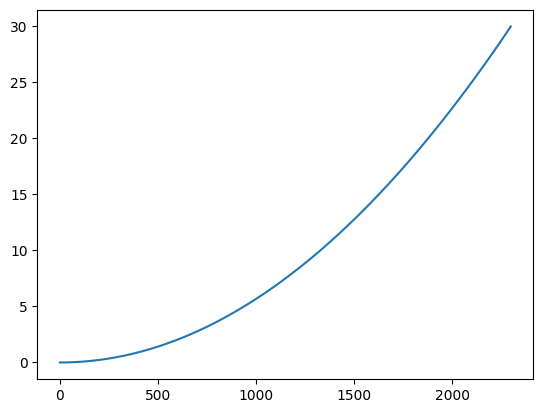

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([ 0.        , 23.21561243, 46.43122486, ...,  0.        ,
        0.        ,  0.        ])

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  2.322e+01 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 2411
    fjac: [[ 0.000e+00  0.000e+00 ...  4.398e-20  4.328e-20]
           [ 0.000e+00  0.000e+00 ...  6.034e-18  5.938e-18]
           ...
           [ 0.000e+00  0.000e+00 ...  4.913e-13 -7.788e-14]
           [ 0.000e+00  0.000e+00 ... -8.162e-13  1.841e-12]]
       r: [ 8.720e+04  8.720e+04 ...  0.000e+00  0.000e+00]
     qtf: [-1.208e-01 -5.492e+04 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
q0=root_.x

In [106]:
q0

array([ 0.        , 23.21561243, 46.43122486, ...,  0.        ,
        0.        ,  0.        ])

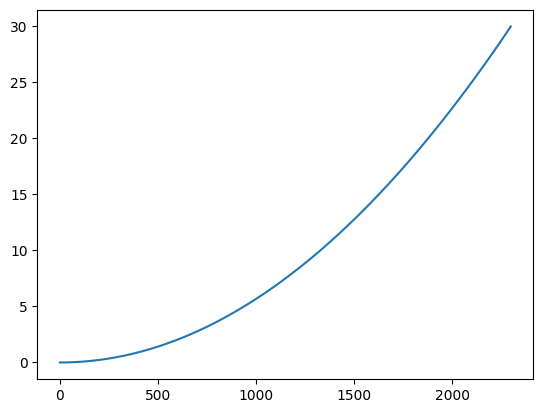

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [113]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [114]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [115]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [116]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [117]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [118]:
fors

array([[-7.89568425e+03,  3.28768749e+02,  3.52030600e+02],
       [ 2.15251930e-07,  1.88235426e-05, -1.14354771e-05],
       [ 5.36092557e-07,  7.46814767e-05, -5.70691191e-05],
       [ 7.43311830e-07,  4.94067349e-05, -1.32129062e-05],
       [ 1.17439777e-06,  1.95298344e-06,  7.09289452e-05],
       [ 9.42498446e-07,  5.51808625e-05, -9.72300768e-06],
       [ 2.05636024e-06,  4.92846593e-05,  7.72997737e-06],
       [ 1.74902380e-06,  1.06471244e-04,  3.89311463e-05],
       [ 2.44006515e-06,  2.62837857e-05,  4.27034684e-05],
       [ 2.23517418e-06,  8.69855285e-06,  5.34579158e-06],
       [ 4.02331352e-06,  4.08254564e-05,  4.47034836e-08],
       [ 2.81631947e-06, -9.00033928e-06, -3.23392451e-05],
       [ 5.12599945e-06, -5.09433448e-05, -2.00523064e-05],
       [ 3.99351120e-06, -1.69053674e-05,  5.18411398e-05],
       [ 4.23192978e-06,  3.37101519e-05, -1.52587891e-05],
       [ 3.48687172e-06,  6.11153795e-05, -4.84809279e-05],
       [ 5.66244125e-07, -4.17381525e-05

### Vessle Simulation

In [119]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [120]:
N*sampleTime

100.0

In [121]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [122]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [123]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

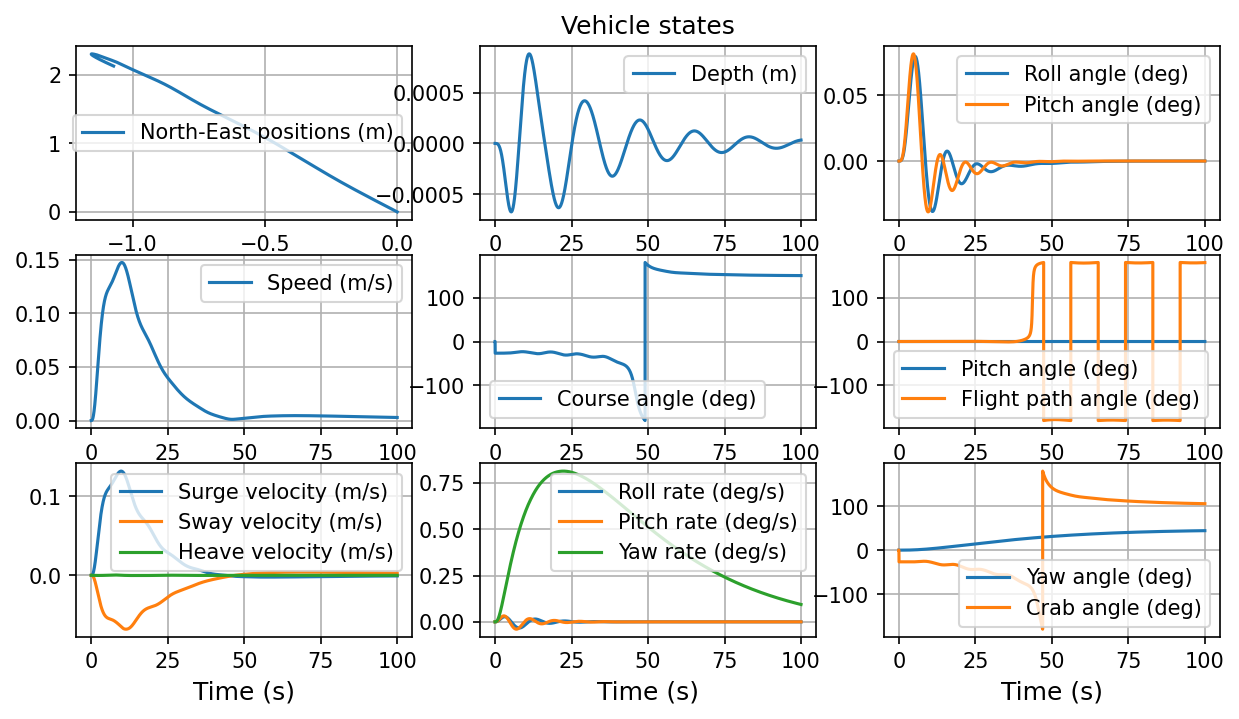

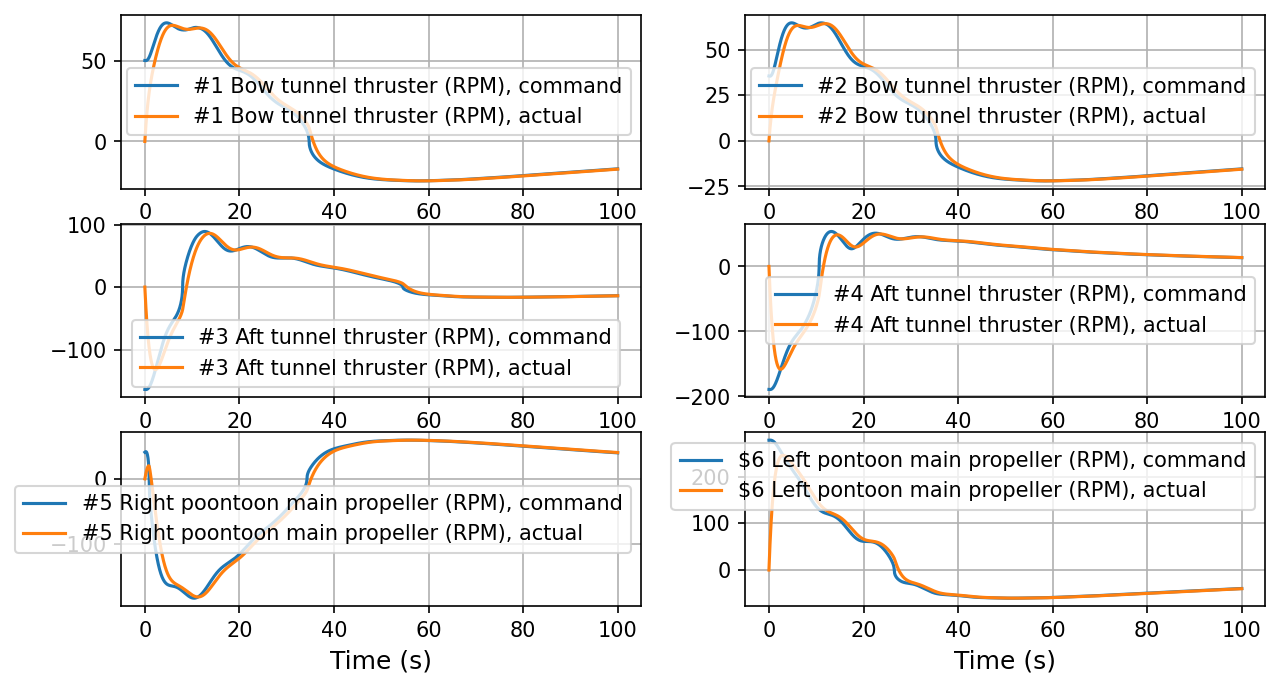

In [124]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [125]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

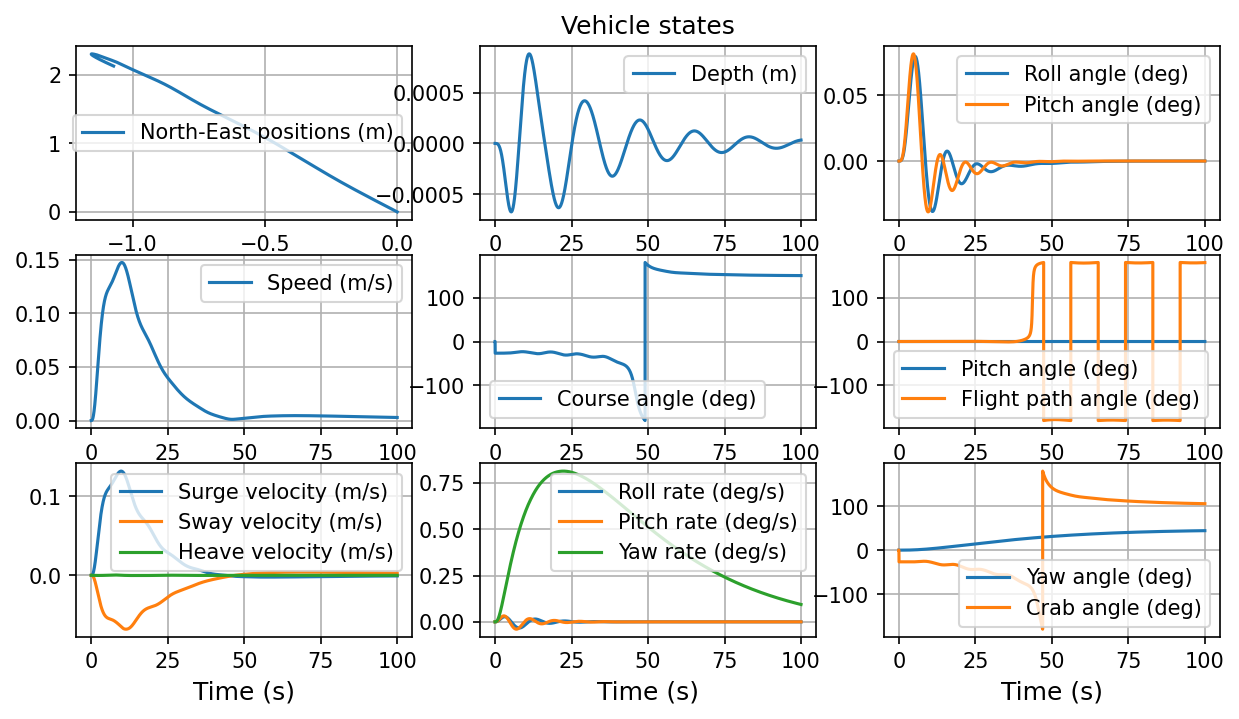

In [126]:
plotVehicleStates(simTime, simData, 3)

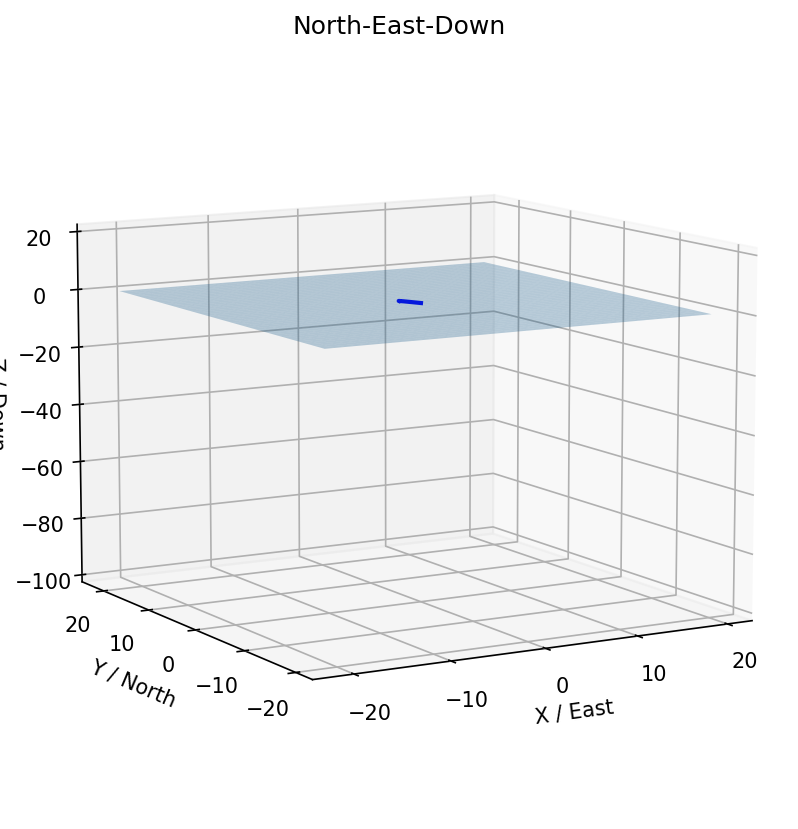

In [127]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [128]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [129]:
idx=1/0.01

In [130]:
idx

100.0

In [131]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [132]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [133]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [134]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [135]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [136]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [137]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [138]:
tspan = (0., 100)
T_ = MyTime()

In [139]:
coefs = [1, 1, 1, 1, 1, 1]

In [140]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  3.3225885815622826e-05  Iteration wall clock time:  0:00:00.885761
Physical time:  1.0470255602788086  Iteration wall clock time:  0:00:10.460947
Physical time:  2.243776482534214  Iteration wall clock time:  0:00:07.843765
Physical time:  3.01604001630454  Iteration wall clock time:  0:00:04.479626
Physical time:  4.088895697880127  Iteration wall clock time:  0:00:05.662380
Physical time:  5.049925857167789  Iteration wall clock time:  0:00:04.164505
Physical time:  6.27448064357064  Iteration wall clock time:  0:00:05.110104
Physical time:  7.055498449109294  Iteration wall clock time:  0:00:04.208603
Physical time:  8.097462457098317  Iteration wall clock time:  0:00:05.038678
Physical time:  9.061790668707363  Iteration wall clock time:  0:00:04.031053
Physical time:  10.01585479838762  Iteration wall clock time:  0:00:03.782828
Physical time:  11.05621031839907  Iteration wall clock time:  0:00:04.264455
Physical time:  12.077254137438675  Iteration wall clock tim

### Results

In [141]:
fin=us

In [142]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.323e-03 ...  9.734e+01  1.000e+02]
        y: [[ 0.000e+00  3.352e-15 ...  1.708e+01  1.757e+01]
            [ 2.322e+01  2.322e+01 ...  2.322e+01  2.322e+01]
            ...
            [ 0.000e+00 -1.592e-05 ...  4.699e-04 -1.117e-03]
            [ 0.000e+00 -1.625e-05 ...  4.682e-04 -1.142e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 332
     njev: 0
      nlu: 0

In [143]:
t=fin.t

In [144]:
fin=fin.y.T

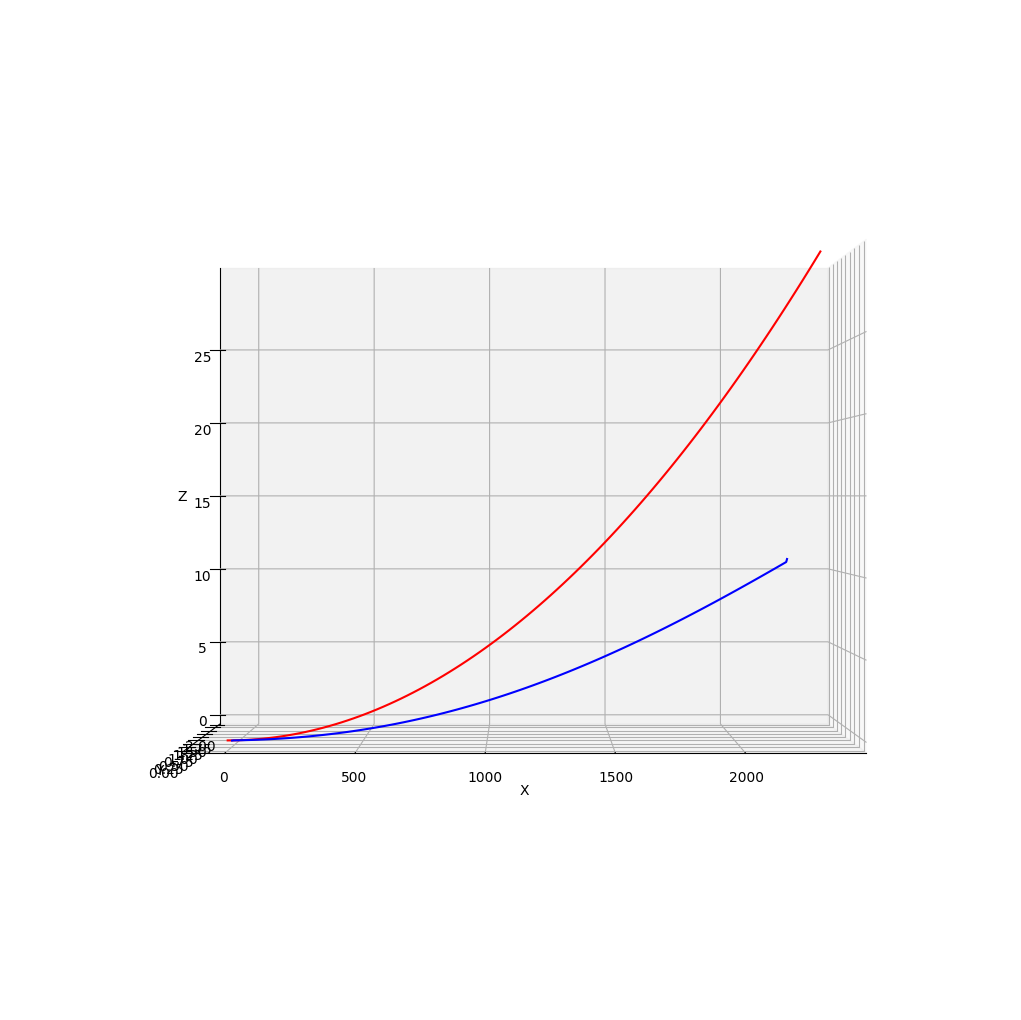

In [145]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [146]:
X,Y,Z

(array([  17.56971138,   23.215593  ,   46.43120568,   69.64681873,
          92.86243216,  116.07804597,  139.29366016,  162.50927471,
         185.72488965,  208.94050495,  232.15612064,  255.3717367 ,
         278.58735314,  301.80296996,  325.01858717,  348.23420478,
         371.44982278,  394.66544119,  417.88106001,  441.09667925,
         464.31229892,  487.52791903,  510.74353959,  533.9591606 ,
         557.17478209,  580.39040406,  603.60602653,  626.8216495 ,
         650.037273  ,  673.25289704,  696.46852164,  719.68414681,
         742.89977257,  766.11539894,  789.33102594,  812.54665358,
         835.7622819 ,  858.9779109 ,  882.19354061,  905.40917106,
         928.62480226,  951.84043425,  975.05606704,  998.27170066,
        1021.48733514, 1044.70297051, 1067.91860679, 1091.134244  ,
        1114.34988219, 1137.56552137, 1160.78116159, 1183.99680287,
        1207.21244523, 1230.42808872, 1253.64373337, 1276.85937921,
        1300.07502628, 1323.2906746 , 1346.50632

In [147]:
X0,Y0,Z0

(array([   0.        ,   23.21561243,   46.43122486,   69.64683729,
          92.86244971,  116.07806214,  139.29367457,  162.509287  ,
         185.72489943,  208.94051186,  232.15612428,  255.37173671,
         278.58734914,  301.80296157,  325.018574  ,  348.23418643,
         371.44979885,  394.66541128,  417.88102371,  441.09663614,
         464.31224857,  487.527861  ,  510.74347343,  533.95908585,
         557.17469828,  580.39031071,  603.60592314,  626.82153557,
         650.037148  ,  673.25276042,  696.46837285,  719.68398528,
         742.89959771,  766.11521014,  789.33082257,  812.54643499,
         835.76204742,  858.97765985,  882.19327228,  905.40888471,
         928.62449714,  951.84010956,  975.05572199,  998.27133442,
        1021.48694685, 1044.70255928, 1067.91817171, 1091.13378414,
        1114.34939656, 1137.56500899, 1160.78062142, 1183.99623385,
        1207.21184628, 1230.42745871, 1253.64307113, 1276.85868356,
        1300.07429599, 1323.28990842, 1346.50552

In [148]:
us=fin.T

In [149]:
us.shape

(1200, 55)

In [150]:
12*50

600

In [151]:
us.T[:,4*node_N+99]

array([ 29.98978026,  29.98977505,  29.98914957,  29.92558433,
        29.38722922,  28.51748949,  27.39999412,  26.09080862,
        24.58590709,  22.85578706,  20.8591416 ,  18.54863539,
        15.87510579,  12.79381504,   9.2739222 ,   5.31013281,
         0.93176009,  -3.79383281,  -8.76096198, -13.81562886,
       -18.7189538 , -23.07189345, -26.23900167, -27.51037102,
       -26.20904794, -21.56104194, -13.06114287,  -1.25950961,
        11.40193535,  21.28757305,  25.95266703,  24.93147234,
        18.59069754,   8.12994027,  -4.02448891, -14.92378884,
       -22.1524805 , -24.18208864, -20.59427855, -12.30969278,
        -1.25806242,   9.96918485,  18.74752789,  23.08975893,
        22.05277885,  15.95003996,   6.22135233,  -4.83507981,
       -14.50139697, -20.45637166, -21.41578892, -17.30629979,
        -9.17069108,   1.16926553,  10.70426049])

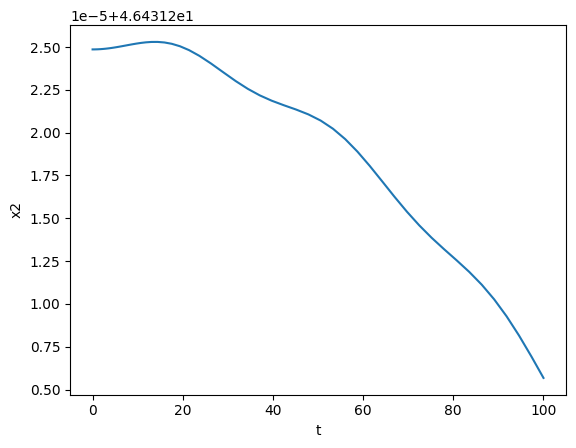

In [152]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

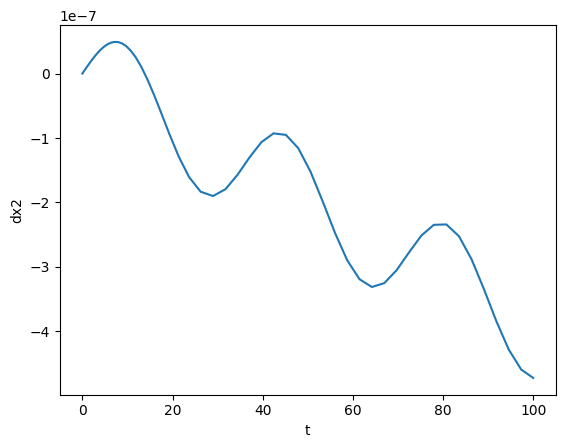

In [153]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

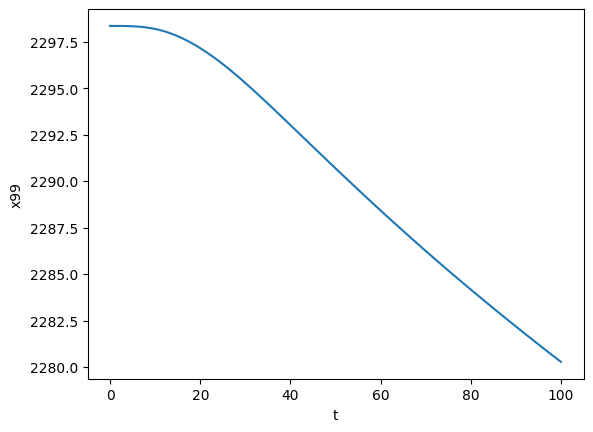

In [154]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x99')
plt.show()

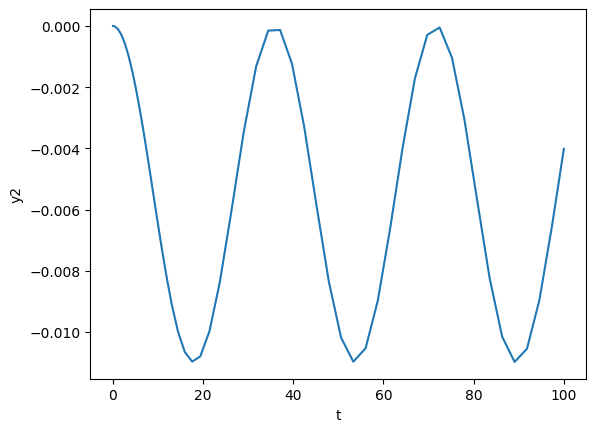

In [155]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

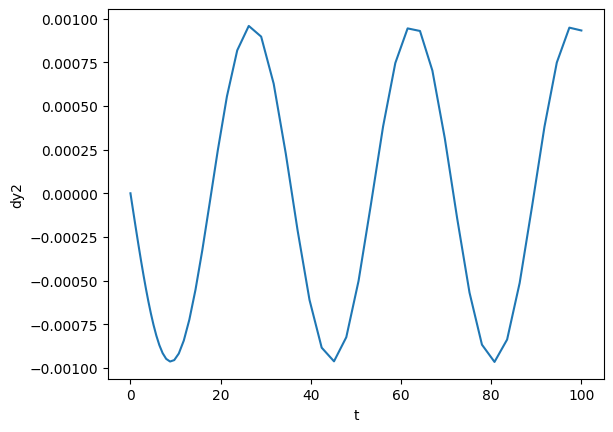

In [156]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

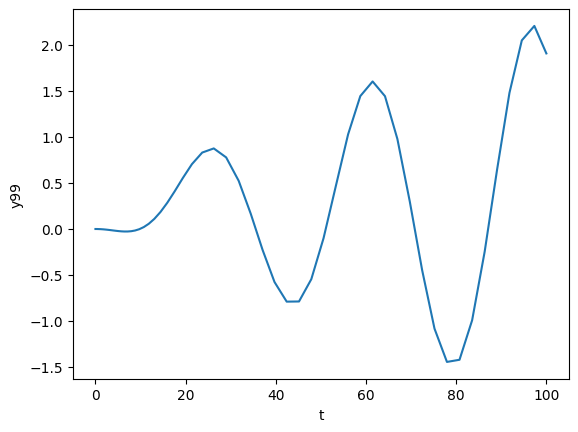

In [157]:
plt.plot(t,us.T[:,2*node_N+99] ,'-')
plt.xlabel('t')
plt.ylabel('y99')
plt.show()

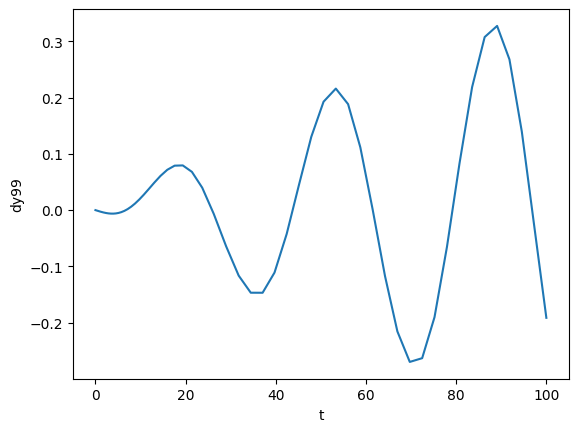

In [158]:
plt.plot(t,us.T[:,3*node_N+99] ,'-')
plt.xlabel('t')
plt.ylabel('dy99')
plt.show()

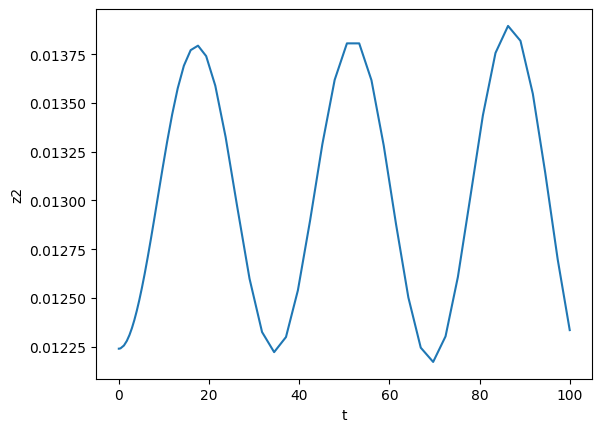

In [159]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

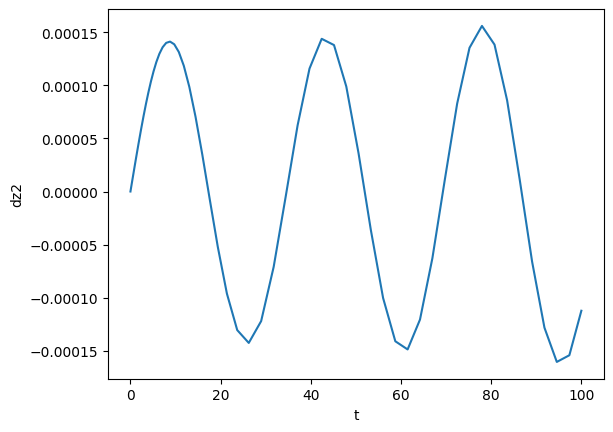

In [160]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

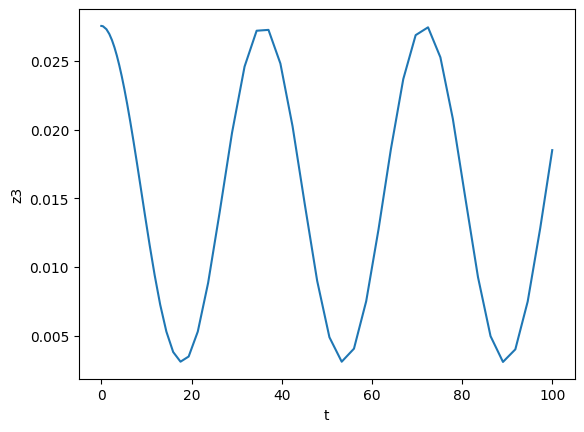

In [161]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

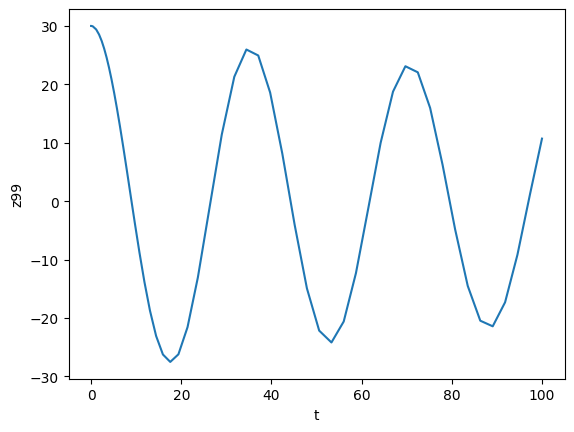

In [162]:
plt.plot(t,us.T[:,4*node_N+99] ,'-')
plt.xlabel('t')
plt.ylabel('z99')
plt.show()

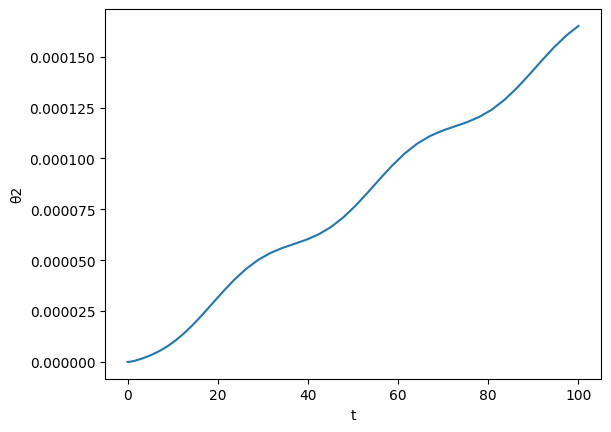

In [163]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

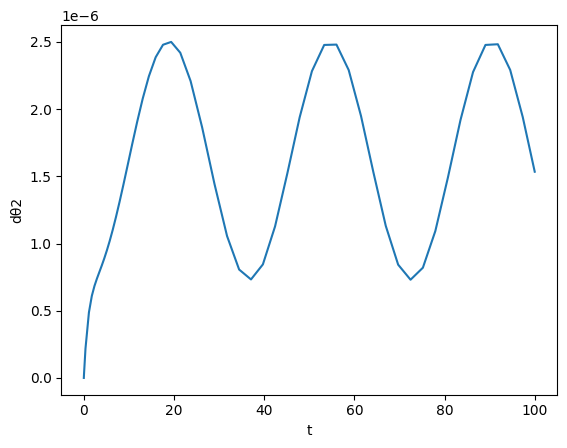

In [164]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

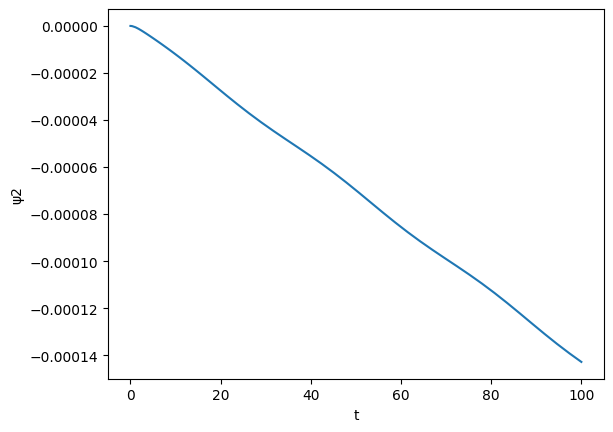

In [165]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

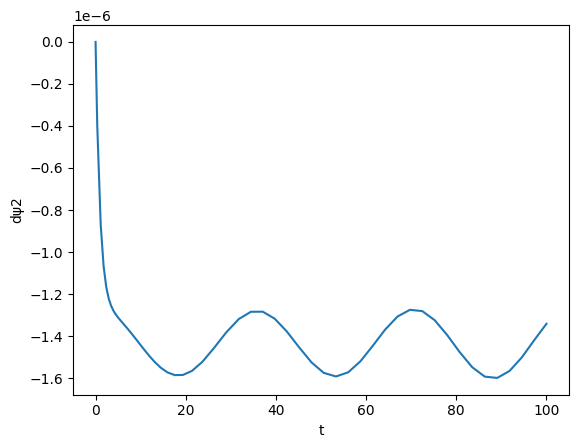

In [166]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

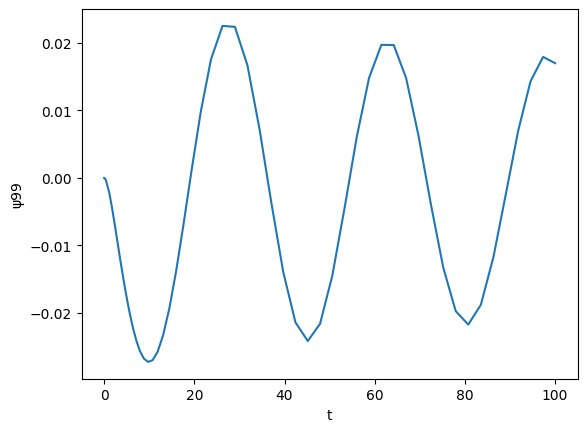

In [167]:
plt.plot(t,us.T[:,10*node_N+99] ,'-')
plt.xlabel('t')
plt.ylabel('ψ99')
plt.show()